<a href="https://colab.research.google.com/github/codedmachine111/ML/blob/master/DCGAN_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [2]:
from tensorflow.keras.datasets.fashion_mnist import load_data

(X_train, y_train),  (X_test, y_test) = load_data()

4422102/4422102 [==============================] - 1s 0us/step


In [3]:
X_train.shape

(60000, 28, 28)

In [4]:
X_train[0].shape

(28, 28)

In [5]:
X_train = X_train.reshape(-1,28,28,1)
X_train.shape

(60000, 28, 28, 1)

## Visualize data

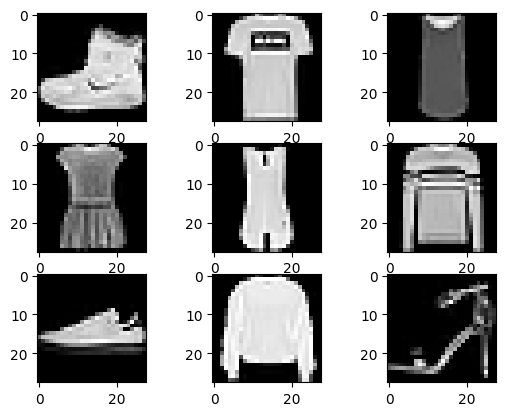

In [6]:
fig, axes = plt.subplots(3,3)
index=0
for i in range(3):
  for j in range(3):
    axes[i,j].imshow(X_train[index].reshape(28,28), cmap='gray')
    index += 1

## Normalizing

In [7]:
X_train = X_train / 255.0

In [8]:
X_train = X_train *2 -1

In [9]:
X_train.max(), X_train.min()

(1.0, -1.0)

## Generator

In [10]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Reshape, Conv2DTranspose, BatchNormalization, Dense

generator = Sequential()

generator.add(Dense(7*7*128, input_shape=[100]))
generator.add(Reshape([7,7,128]))
generator.add(BatchNormalization())

generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding='same', activation='relu'))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(1, kernel_size=5, strides=2, padding='same', activation='tanh'))

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              633472    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 batch_normalization (Batch  (None, 7, 7, 128)         512       
 Normalization)                                                  
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        204864    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 64)        256       
 chNormalization)                                                
                                                        

## Discriminator

In [11]:
from tensorflow.keras.layers import LeakyReLU, Dropout, Conv2D, Flatten
discriminator = Sequential()

discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding='same', activation=LeakyReLU(0.3), input_shape=[28,28,1]))
discriminator.add(Dropout(0.5))

discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same', activation=LeakyReLU(0.3)))
discriminator.add(Dropout(0.5))

discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6273      
                                                                 
Total params: 212865 (831.50 KB)
Trainable params: 212

In [12]:
DCGAN = Sequential([generator, discriminator])

discriminator.compile(optimizer='adam', loss='binary_crossentropy')
discriminator.trainable = False

In [13]:
DCGAN.compile(optimizer='adam', loss='binary_crossentropy')
print(DCGAN.layers)

DCGAN.summary()

[<keras.src.engine.sequential.Sequential object at 0x7e925148a9e0>, <keras.src.engine.sequential.Sequential object at 0x7e92513fac80>]
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 28, 28, 1)         840705    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1053570 (4.02 MB)
Trainable params: 840321 (3.21 MB)
Non-trainable params: 213249 (833.00 KB)
_________________________________________________________________


## Training DCGAN

In [22]:
EPOCHS = 70
NOISE_SHAPE = 100
BATCH_SIZE= 100

In [23]:
def train_DCGAN(epochs=EPOCHS, batch_size=BATCH_SIZE, noise_shape=NOISE_SHAPE):
  for epoch in range(epochs):
    print(f'Epoch : {epoch}')

    for i in range(X_train.shape[0] // batch_size):
      if (i+1)%50 == 0:
        print(f'Batch number : {i+1}')

      noise = np.random.normal(size=[batch_size, noise_shape])

      # Generated samples
      gen_images = generator.predict_on_batch(noise)

      # Training discriminator on real images
      discriminator.trainable=True
      train_data = X_train[i*batch_size : (i+1)*batch_size]
      train_labels = np.ones(shape=(batch_size,1))
      d_loss_real = discriminator.train_on_batch(train_data, train_labels)

      # Training discriminator on generated images
      train_labels = np.zeros(shape=(batch_size,1))
      d_loss_gen = discriminator.train_on_batch(gen_images, train_labels)

      # Training generator
      noise = np.random.normal(size=[batch_size, noise_shape])
      train_labels = np.ones(shape=(batch_size,1))
      discriminator.trainable = False

      d_g_loss = DCGAN.train_on_batch(noise, train_labels)

    # For every 10 epochs print generated images
    if(epochs %10 == 0):
      SAMPLES = 10
      generated = generator.predict(np.random.normal(loc=0, scale=1, size=(SAMPLES, noise_shape)))

      for i in range(SAMPLES):
        plt.subplot(2,5, i+1)
        plt.imshow(generated[i].reshape(28,28), cmap='gray')
        plt.xticks([])
        plt.yticks([])
      plt.show();
  print("Training Completed!")

Epoch : 0
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 17ms/step


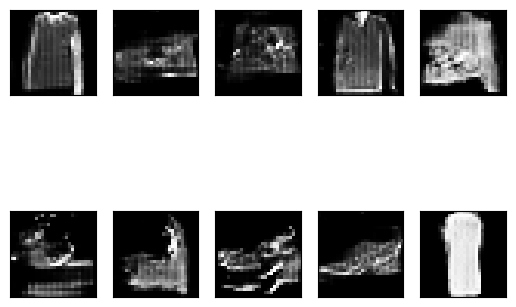

Epoch : 1
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 25ms/step


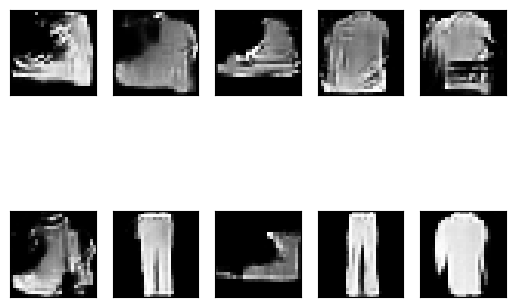

Epoch : 2
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 17ms/step


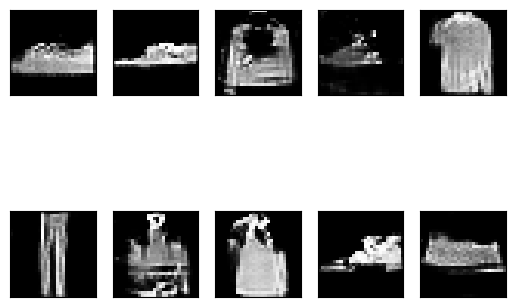

Epoch : 3
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 17ms/step


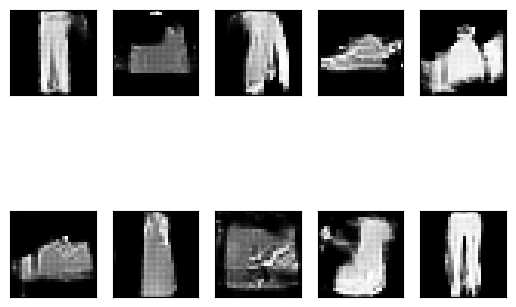

Epoch : 4
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 26ms/step


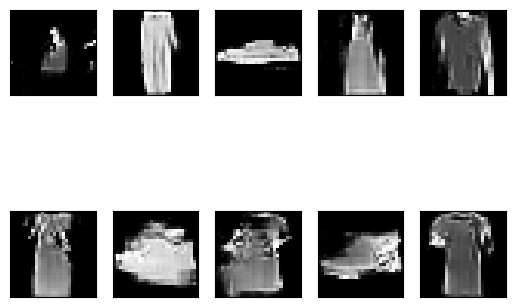

Epoch : 5
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 28ms/step


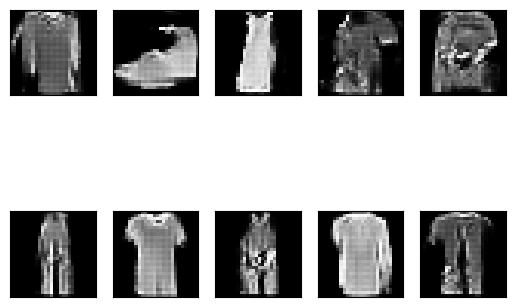

Epoch : 6
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 18ms/step


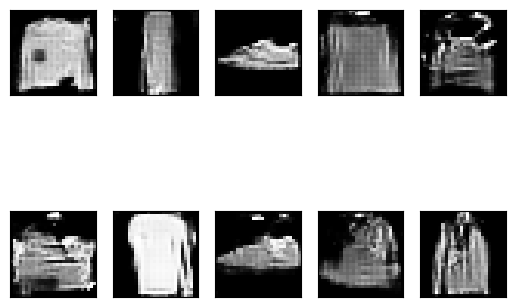

Epoch : 7
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 17ms/step


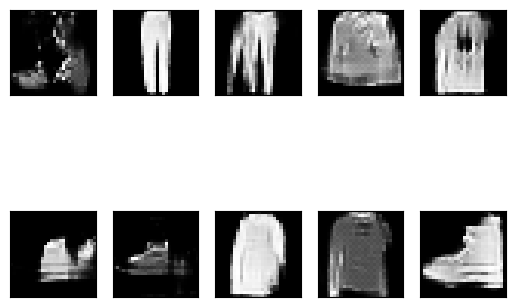

Epoch : 8
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 17ms/step


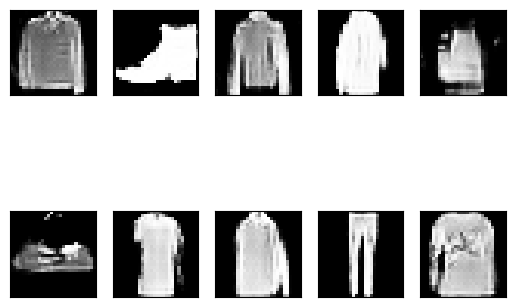

Epoch : 9
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 24ms/step


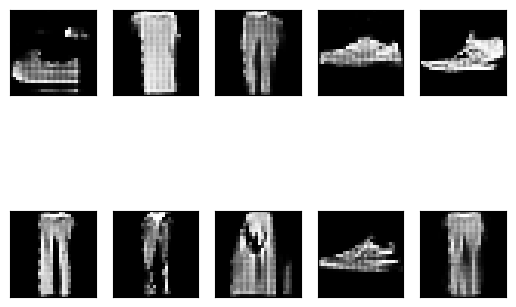

Epoch : 10
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 17ms/step


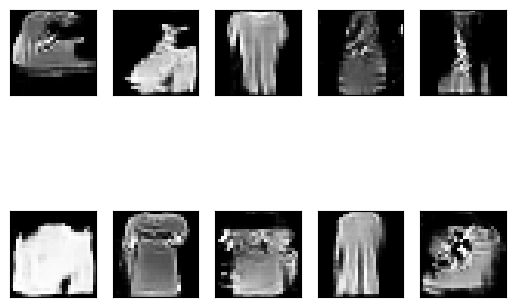

Epoch : 11
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 18ms/step


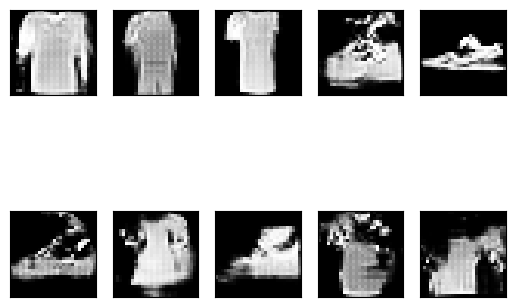

Epoch : 12
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 27ms/step


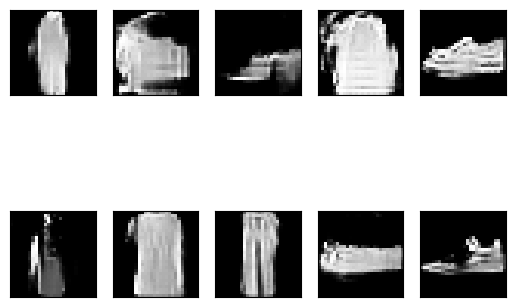

Epoch : 13
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 17ms/step


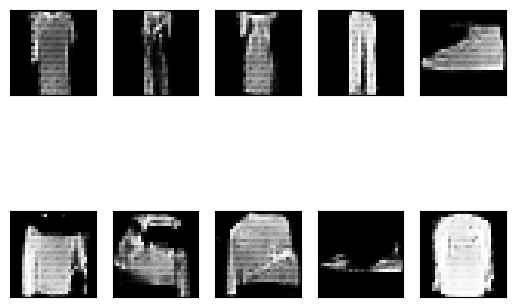

Epoch : 14
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 17ms/step


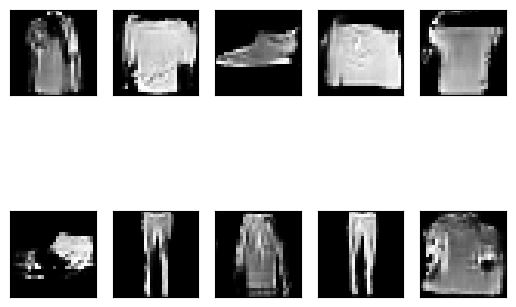

Epoch : 15
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 18ms/step


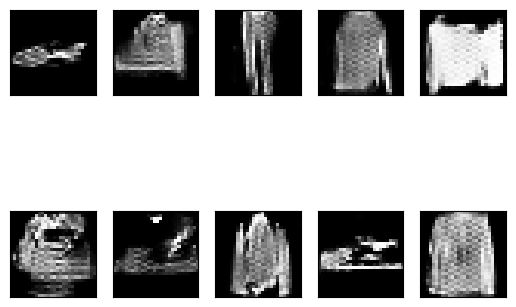

Epoch : 16
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 16ms/step


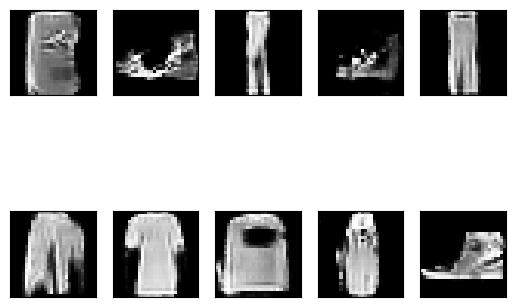

Epoch : 17
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 21ms/step


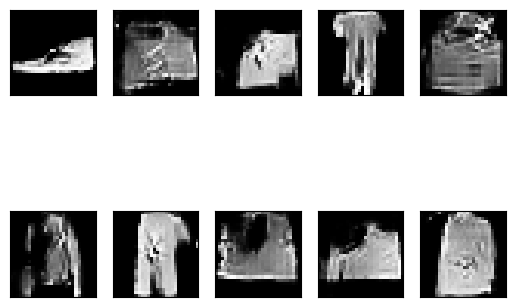

Epoch : 18
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 19ms/step


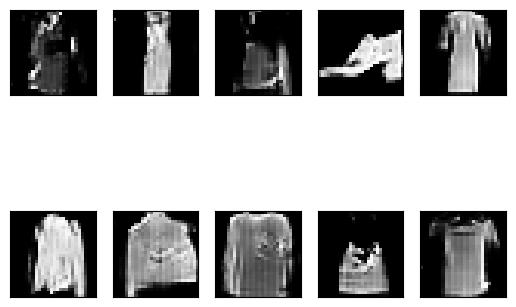

Epoch : 19
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 19ms/step


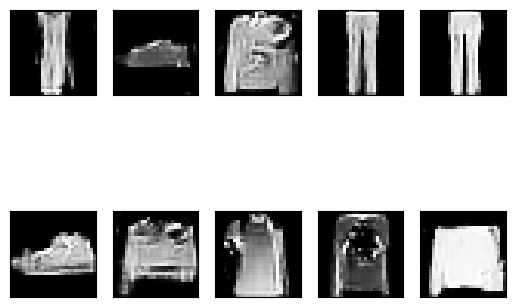

Epoch : 20
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 17ms/step


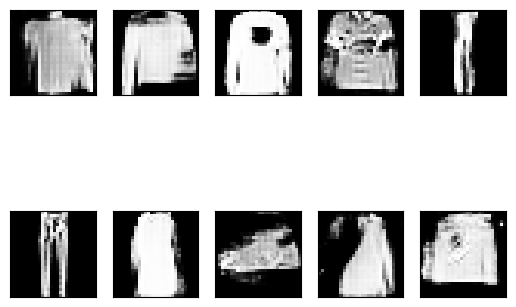

Epoch : 21
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 17ms/step


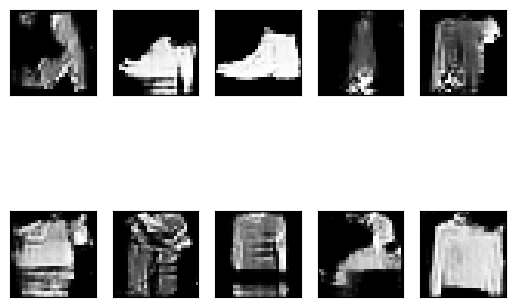

Epoch : 22
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 18ms/step


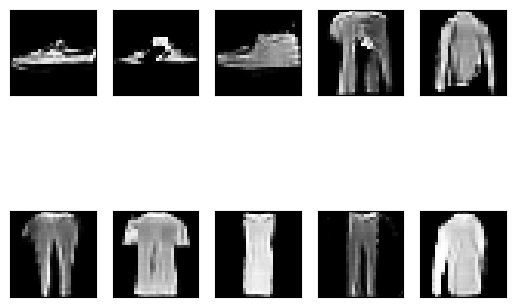

Epoch : 23
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 17ms/step


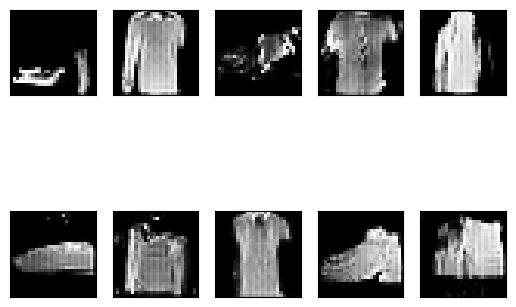

Epoch : 24
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 21ms/step


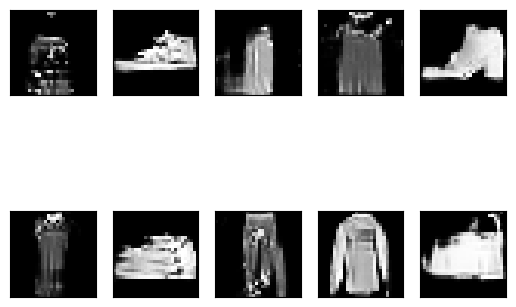

Epoch : 25
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 28ms/step


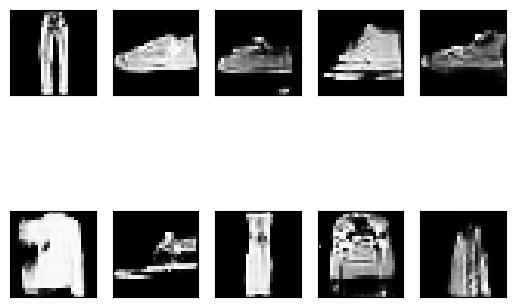

Epoch : 26
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 27ms/step


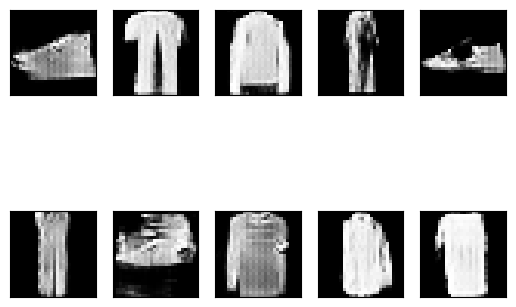

Epoch : 27
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 32ms/step


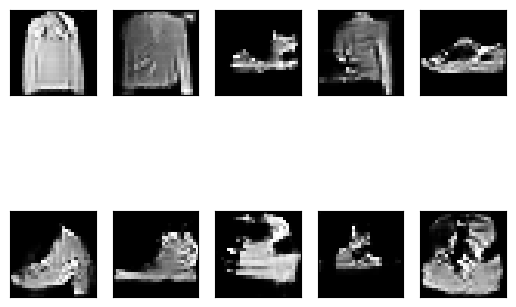

Epoch : 28
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 35ms/step


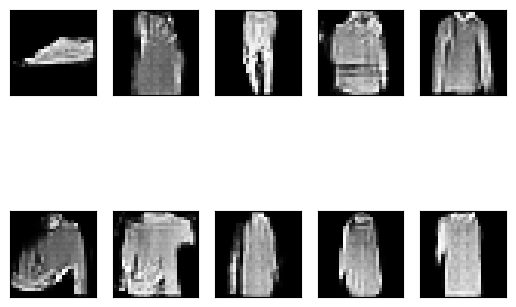

Epoch : 29
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 25ms/step


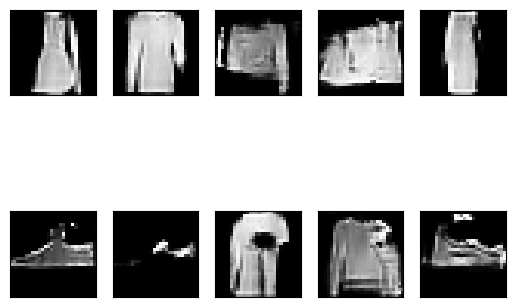

Epoch : 30
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 26ms/step


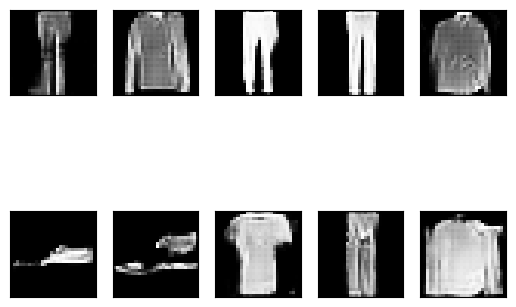

Epoch : 31
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 18ms/step


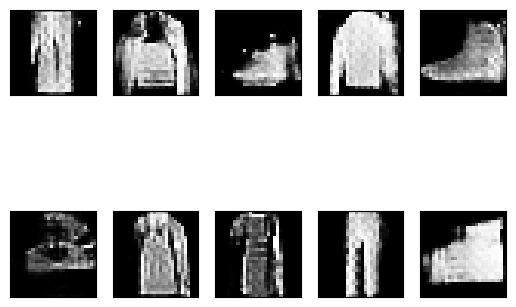

Epoch : 32
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 18ms/step


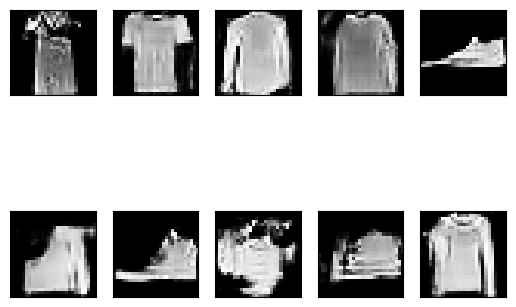

Epoch : 33
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 18ms/step


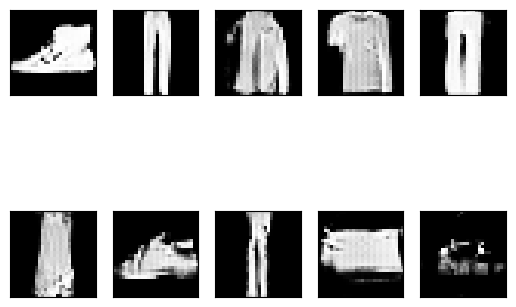

Epoch : 34
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 17ms/step


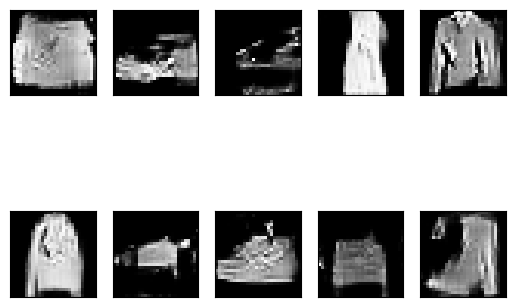

Epoch : 35
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 18ms/step


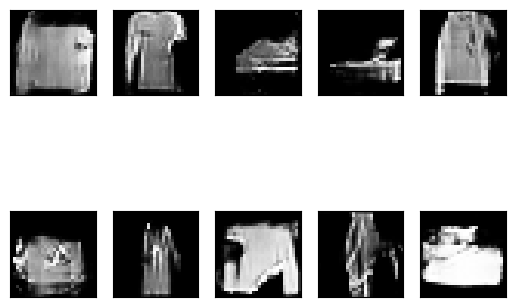

Epoch : 36
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 19ms/step


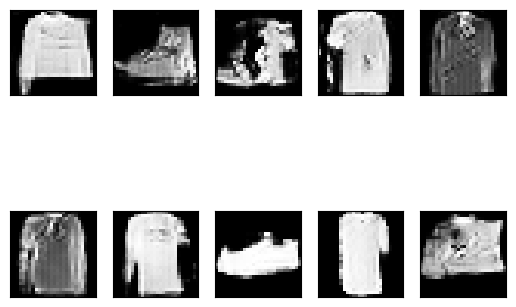

Epoch : 37
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 20ms/step


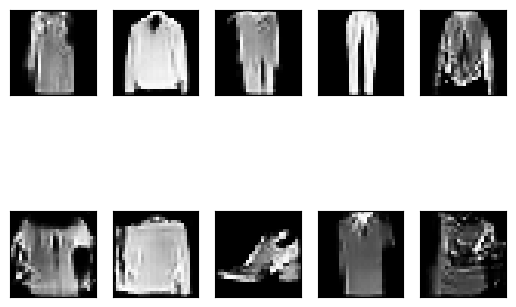

Epoch : 38
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 20ms/step


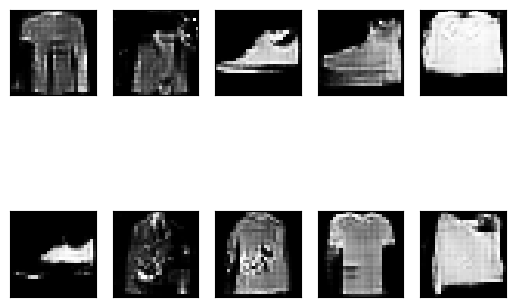

Epoch : 39
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 19ms/step


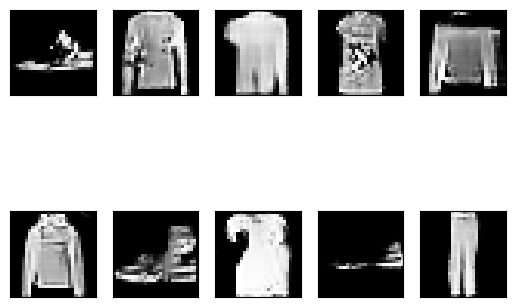

Epoch : 40
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 21ms/step


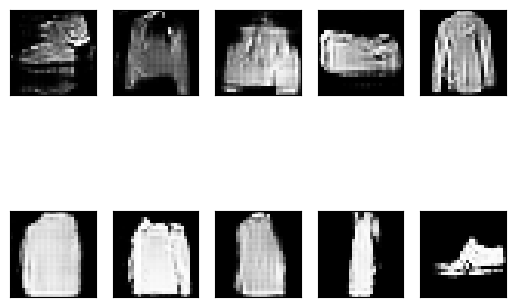

Epoch : 41
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 17ms/step


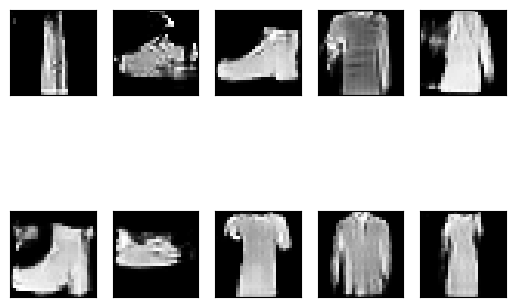

Epoch : 42
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 16ms/step


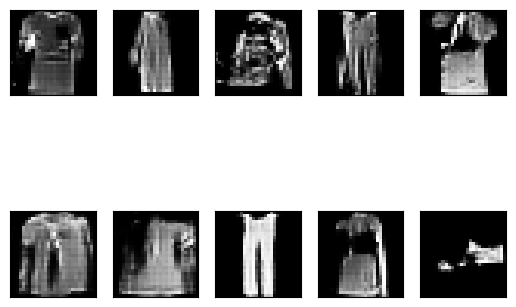

Epoch : 43
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 19ms/step


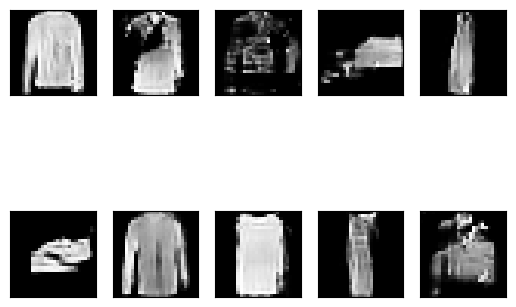

Epoch : 44
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 18ms/step


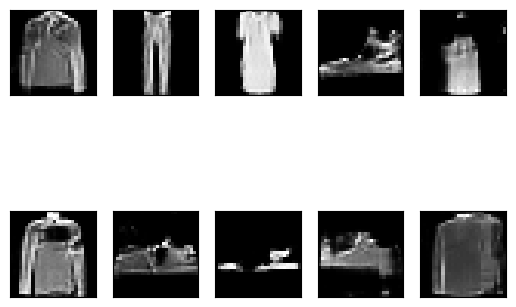

Epoch : 45
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 17ms/step


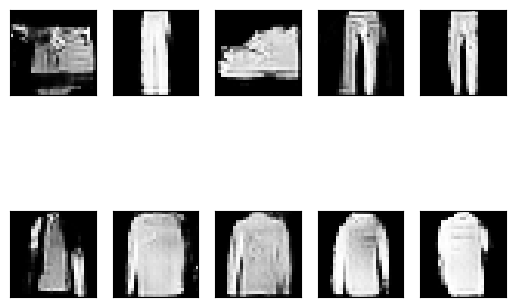

Epoch : 46
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 20ms/step


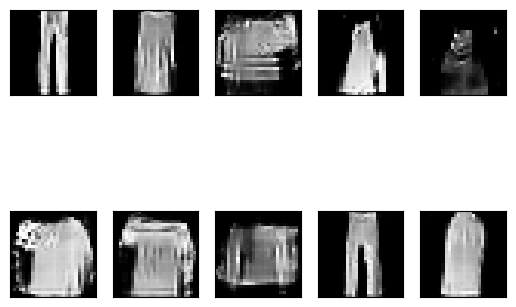

Epoch : 47
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 17ms/step


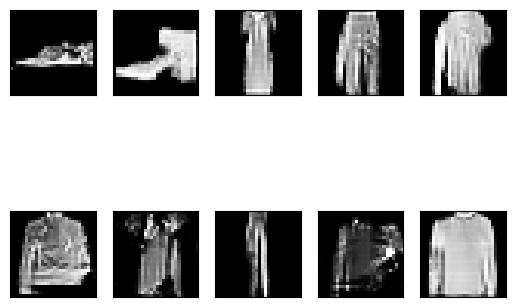

Epoch : 48
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 17ms/step


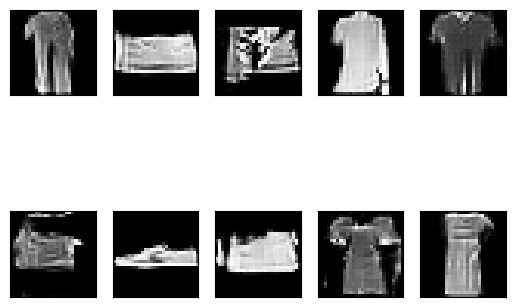

Epoch : 49
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 16ms/step


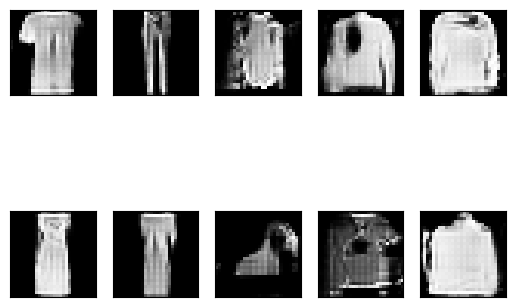

Epoch : 50
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 17ms/step


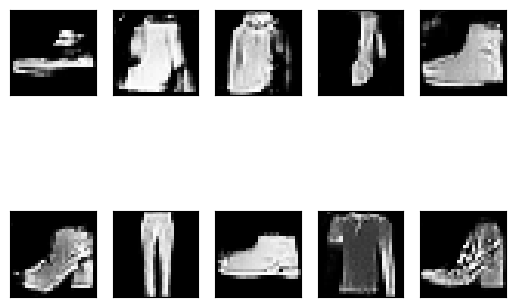

Epoch : 51
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 22ms/step


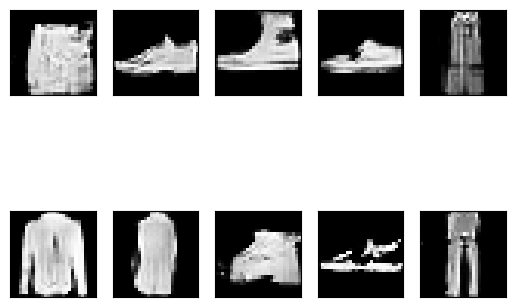

Epoch : 52
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 17ms/step


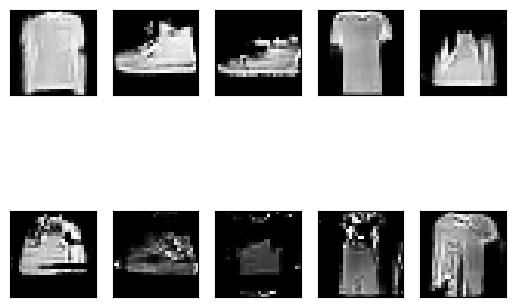

Epoch : 53
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 17ms/step


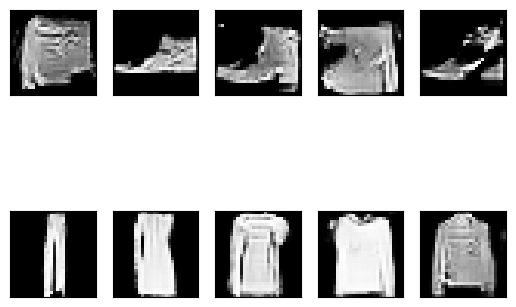

Epoch : 54
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 17ms/step


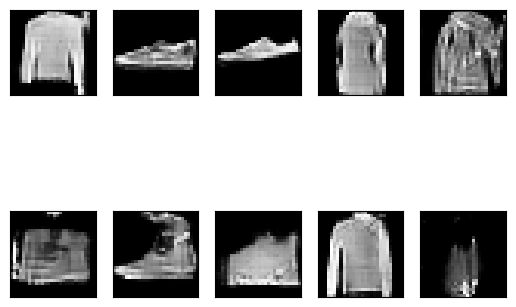

Epoch : 55
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 18ms/step


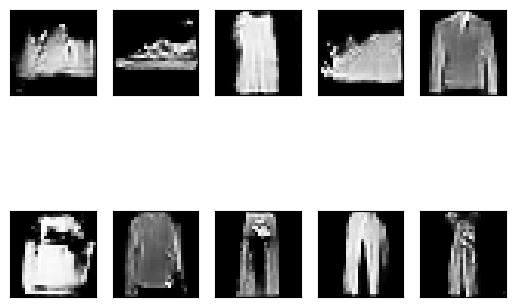

Epoch : 56
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 20ms/step


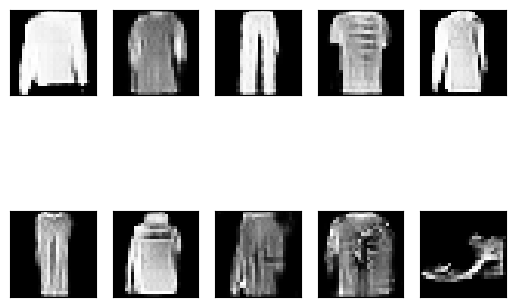

Epoch : 57
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 19ms/step


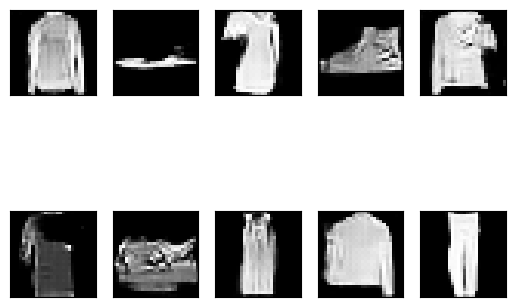

Epoch : 58
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 18ms/step


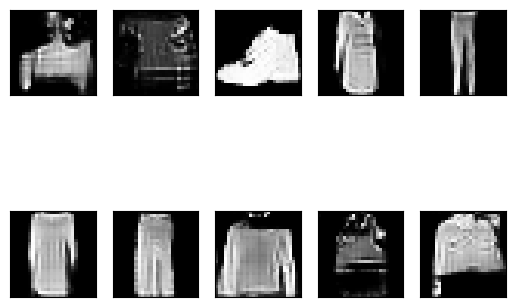

Epoch : 59
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 18ms/step


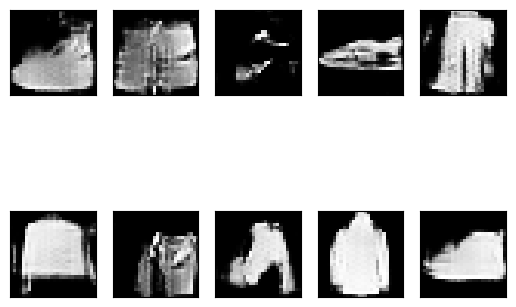

Epoch : 60
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 21ms/step


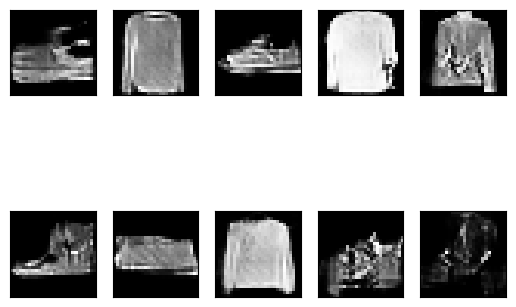

Epoch : 61
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 17ms/step


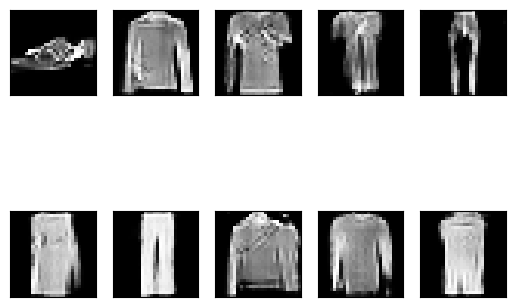

Epoch : 62
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 17ms/step


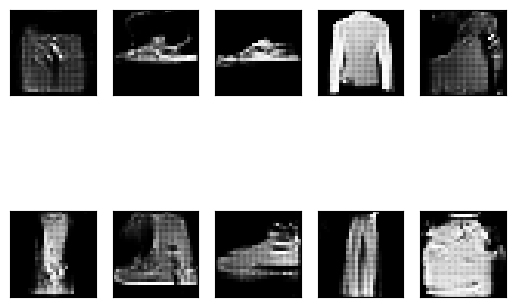

Epoch : 63
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 17ms/step


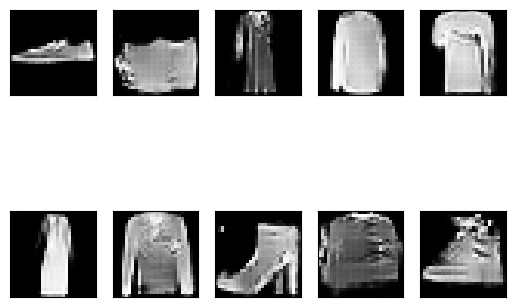

Epoch : 64
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 19ms/step


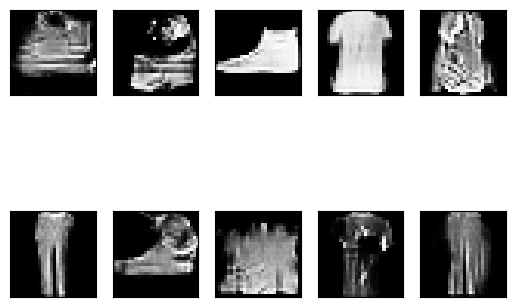

Epoch : 65
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 18ms/step


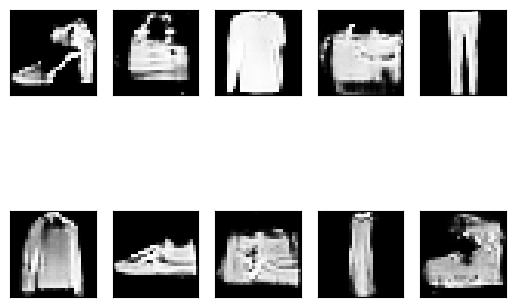

Epoch : 66
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 21ms/step


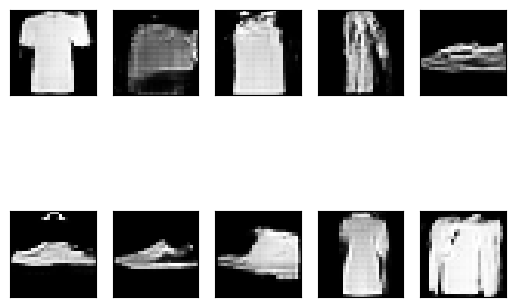

Epoch : 67
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 17ms/step


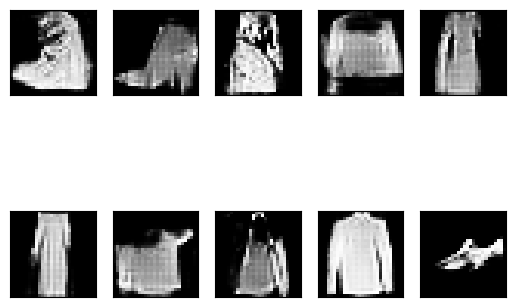

Epoch : 68
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 18ms/step


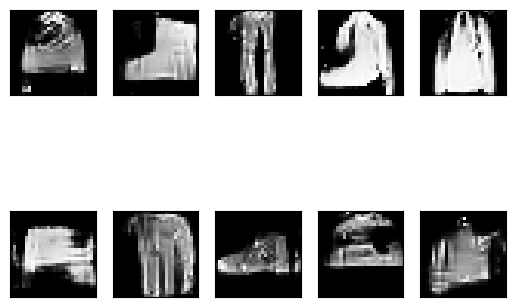

Epoch : 69
Batch number : 50
Batch number : 100
Batch number : 150
Batch number : 200
Batch number : 250
Batch number : 300
Batch number : 350
Batch number : 400
Batch number : 450
Batch number : 500
Batch number : 550
Batch number : 600
1/1 [==============================] - 0s 30ms/step


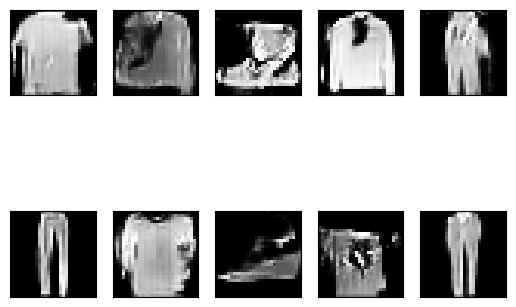

Training Completed!


In [24]:
train_DCGAN();

- Generated images after training